In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import invwishart 
from scipy.stats import multivariate_normal 
from scipy.special import logsumexp
from sklearn import metrics

In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

In [10]:
dirpath = "./../../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

I wrote everything in vectorized format, and should have done in iterative format but will do so in future

Complete Data Log Likelihood:
$$\begin{align}
    \log p(\mathbf{X},\mathbf{z}|\boldsymbol{\theta}) &= \log p(\mathbf{X}_H,\mathbf{X}_O,\mathbf{z}|\boldsymbol{\theta}), \quad \text{where } p(\mathbf{X},\mathbf{z}|\boldsymbol{\theta}) = \sum_i^N  p(\mathbf{x}_i,\mathbf{z}_i|\boldsymbol{\theta})
\end{align}$$

Goal

$$\begin{align}
    \boldsymbol{\hat{\theta}} &\leftarrow \argmax_{\boldsymbol{\theta}} \log p(\mathbf{X}_O| \boldsymbol{\theta})
\end{align}$$
Where,
$$\begin{align}
    \log p(\mathbf{X}_O| \boldsymbol{\theta}) &=  \log \sum_{\mathbf{z}} \sum_{\mathbf{X}_H} p(\mathbf{X}_O, \mathbf{X}_H, \mathbf{z}| \boldsymbol{\theta})
\end{align}$$

Introduce distributon $q(\mathbf{z}, \mathbf{X}_H)$

$$\begin{align}
    \log \sum_{\mathbf{z}} \sum_{\mathbf{X}_H} p(\mathbf{X}_O, \mathbf{X}_H, \mathbf{z}| \boldsymbol{\theta}) = \log \sum_{\mathbf{z}} \sum_{\mathbf{X}_H} q(\mathbf{z}, \mathbf{X}_H) \frac{p(\mathbf{X}_O, \mathbf{X}_H, \mathbf{z}| \boldsymbol{\theta})}{q(\mathbf{z}, \mathbf{X}_H)}
\end{align}$$

Jensen's Inequality
$$\begin{align}
    \log p(\mathbf{X}_O| \boldsymbol{\theta}) \geq  \sum_{\mathbf{z}} \sum_{\mathbf{X}_H} q(\mathbf{z}, \mathbf{X}_H) \log \frac{p(\mathbf{X}_O, \mathbf{X}_H, \mathbf{z}| \boldsymbol{\theta})}{q(\mathbf{z}, \mathbf{X}_H)}
\end{align}$$

Maximize lower bound by setting $q(\mathbf{z}, \mathbf{X}_H) = p(\mathbf{z}, \mathbf{X}_H | \mathbf{X}_O,\boldsymbol{\theta})$, the posterior. Hence,

$$\begin{align}
    p(\mathbf{z}, \mathbf{X}_H | \mathbf{X}_O,\boldsymbol{\theta}) &= \underbrace{p(\mathbf{z}|\mathbf{X}_O,\boldsymbol{\theta})}_{\text{Responsibility}} \times \underbrace{p(\mathbf{X}_H|\mathbf{z},\mathbf{X}_O,\boldsymbol{\theta})}_{\text{Missing Conditional Dist.}}\\\\
        &= \underbrace{\frac{p(\mathbf{z})p(\mathbf{X}_O|\mathbf{z},\boldsymbol{\theta})}{p(\mathbf{X}_O)}}_{\text{Responsibility}} \times \underbrace{p(\mathbf{X}_H|\mathbf{z},\mathbf{X}_O,\boldsymbol{\theta})}_{\text{Missing Conditional Dist.}} \\
        &= \underbrace{\boldsymbol{\gamma}}_{responsibility} \times \underbrace{p(\mathbf{X}_H|\mathbf{z},\mathbf{X}_O,\boldsymbol{\theta})}_{\text{Missing Conditional Dist.}} 
\end{align}$$

Hence

$$\begin{align}
    Q(\boldsymbol{\theta},\boldsymbol{\theta}^{t}) &= \mathbb{E}_{p(\mathbf{z}, \mathbf{X}_H | \mathbf{X}_O,\boldsymbol{\theta}^t)} \left[\log p(\mathbf{X}_H,\mathbf{X}_O,\mathbf{z}|\boldsymbol{\theta}) \right]\\\\
    &= \sum_{\mathbf{z}} \boldsymbol{\gamma} \cdot  \mathbb{E}_{p(\mathbf{X}_H | \mathbf{X}_O,\boldsymbol{\theta}^t,\mathbf{z})}[\log p(\mathbf{X}_H,\mathbf{X}_O,\mathbf{z}|\boldsymbol{\theta}) ]

\end{align}$$

E-Step:

$$
    r_{ik} = \frac{p(z^{(i)} = k|\boldsymbol{\Theta})p(\mathbf{x}_{iO}|\theta,z^{(i)}=k)}{\sum_{k'} p(z^{(i)} = k'|\boldsymbol{\Theta})p(\mathbf{x}_{iO}|\theta,z^{(i)}=k')}
$$

M-Step:
$$\begin{align}
    &\boldsymbol{\pi}_k = \frac{N_k}{N}\\\\

    &\boldsymbol{\mu}_k = \frac{1}{N_k}\sum_i \gamma_{ik} \cdot \mathbb{E}[\mathbf{x}_{i}|z_n=k] = \frac{1}{N_k}\sum_i \gamma_{ik} \cdot (\mathbb{E}[\mathbf{x_{ih}}|z_n=k],\mathbf{x}_{iv}) = \frac{1}{N_k} \sum_i^N \gamma_{ik} \cdot(\mathbf{m}_{i,k};\mathbf{x}_{iv})\\\\


    &\boldsymbol{\Sigma}_k = \frac{1}{N_k}\sum_i \gamma_{ik} \cdot( \mathbb{E}[\mathbf{x}_i\mathbf{x}_i^T]-\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T)\\\\

\end{align}$$
Where,
$$\begin{align}
    \mathbf{x}_{ih}|\mathbf{x}_{io},\theta &\sim \mathcal{N}(\mathbf{m}_i,\mathbf{V}_i)\\ \mathbf{m}_i &= \boldsymbol{\mu}_h + \boldsymbol{\Sigma}_{ho}\boldsymbol{\Sigma}_{oo}^{-1}(\mathbf{x}_{io} - \boldsymbol{\mu}_o)\\
    \mathbf{V}_i &= \boldsymbol{\Sigma}_{hh} - \boldsymbol{\Sigma}_{ho}\boldsymbol{\Sigma}_{oo}^{-1}\boldsymbol{\Sigma}_{oh}
\end{align}$$
$$\begin{align}
    &\mathbb{E}[\mathbf{x}_i\mathbf{x}_i^T] = \left[\begin{matrix} 
        \mathbb{E}[\mathbf{x}_{ih}\mathbf{x}_{ih}^T] & \mathbb{E}[\mathbf{x}_{ih}]\mathbf{x}_{iv}^T\\ \mathbf{x}_{iv}\mathbb{E}[\mathbf{x}_{ih}]^T & \mathbf{x}_{iv}\mathbf{x}_{iv}^T
    \end{matrix}\right]\\\\

    & \mathbb{E}[\mathbf{x}_{ih}\mathbf{x}_{ih}^T] = \mathbb{E}[\mathbf{x}_{ih}]\mathbb{E}[\mathbf{x}_{ih}]^T + \mathbf{V}_i

\end{align}$$

In [ ]:
def e_step(X,μs,Σs,πs,missing_mask,missing,K,eps=1e-14):
    N,D = X.shape

    R = np.zeros((N,K))

    if not missing : 
        for k in range(K):
            R[:,k] = np.log(πs[k] + eps) + multivariate_normal.logpdf(X, mean=μs[k], cov=Σs[k],allow_singular=True)
    else:
        for i in range(N):
            miss_mask = missing_mask[i]
            obs_mask = ~miss_mask

            for k in range(K):
                μ_o = μs[k][obs_mask]
                Σ_oo = Σs[k][np.ix_(obs_mask, obs_mask)]

                R[i,k] = np.log(πs[k] + eps) + multivariate_normal.logpdf(X[i,obs_mask],μ_o,Σ_oo,allow_singular=True)

    log_norm = logsumexp(R, axis=1, keepdims=True)
    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R, loglik

In [ ]:
def m_step(X,R,μs,Σs,missing_mask,missing,K):
    N,D = X.shape
    obs_mask = ~missing_mask

    nk = R.sum(axis=0)
    πs = nk / N

    if not missing:
        μ = (R.T @ X)/nk[:,None]
        # (N,K,D) = (N,D) - (K,D)
        diff = X[:, None, :] - μ[None, :, :]
        # (N,K,D,D) = (N,K,D) * (N,K,D)
        outer = diff[:, :, :, None] * diff[:, :, None, :]
        weighted_outer = R[:, :, None, None] * outer  # (N, K, D, D)
        Σ = weighted_outer.sum(axis=0) / nk[:, None, None]
        return πs, μ, Σ
    else:
        new_μs = np.zeros((K,D))
        new_Σs = np.zeros((K,D,D))

        for i in range(N):
            miss_mask = missing_mask[i]
            obs_mask = ~miss_mask

            for k in range(K):
                μ = μs[k]
                Σ = Σs[k]

                μ_h = μ[miss_mask]
                μ_o = μ[obs_mask]
                Σ_oh = Σ[np.ix_(obs_mask, miss_mask)]
                Σ_ho = Σ[np.ix_(miss_mask, obs_mask)]
                Σ_oo = Σ[np.ix_(obs_mask, obs_mask)]
                Σ_hh = Σ[np.ix_(miss_mask, miss_mask)]

                m_i = μ_h + Σ_ho @ np.linalg.inv(Σ_oo) @ (X[i,obs_mask] - μ_o)
                V_i = Σ_hh - Σ_ho @ np.linalg.inv(Σ_oo) @ Σ_oh

                x_hat = X[i].copy()
                x_hat[miss_mask] = m_i
                new_μs[k] += R[i,k] * x_hat 

                outer = np.outer(x_hat, x_hat)
                if np.any(miss_mask):
                    outer[np.ix_(miss_mask, miss_mask)] += V_i 

                new_Σs[k] += R[i, k] * outer

        new_μs /= nk[:, None]
        for k in range(K):
            μ_k = new_μs[k][:, None]  # D x 1
            new_Σs[k] /=  nk[k] 
            new_Σs[k] -= μ_k @ μ_k.T
    return πs,new_μs,new_Σs           



In [ ]:
def em_algorithm(X,K,max_iters=100,tol=1e-4):
    N,D = X.shape

    missing_mask = np.isnan(X)
    missing = np.any(missing_mask)

    μs = np.zeros((K,D)) + rng.gamma(1.0, 0.1, size=(K, D))
    Σs = np.array([np.eye(D) for _ in range(K)])
    R = rng.dirichlet(alpha=np.full(K, 1), size=N)
    πs = np.sum(R, axis=0)

    loglikes = []

    for i in range(0,max_iters):
        R,ll = e_step(X,μs,Σs,πs,missing_mask,missing,K)
        loglikes.append(ll)

        πs,μs,Σs = m_step(X,R,μs,Σs,missing_mask,missing,K)

        zs = np.argmax(R, axis=1)

        if len(loglikes) > 1 and np.abs(loglikes[-1] - loglikes[-2]) < tol : break

    return zs,πs,μs,Σs,loglikes

In [138]:
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,X_train.shape[1]), X_train.shape[1]//2)
    X_cover1[i][indices] = np.nan

In [233]:
zs,πs,μs,Σs,ll = em_algorithm(X_cover1,3,20)

True


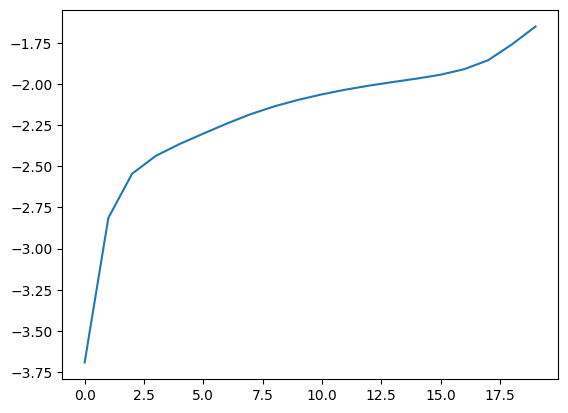

In [229]:
plt.plot(ll)
plt.show()

In [234]:
metrics.adjusted_rand_score(y_train, zs)

0.05366626000215293